## **Realistic Elements**

Some required code snippets, same as initial notebook.

In [1]:
pip install ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.7 MB/s eta 0:00:00


In [2]:
import ujson
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [3]:
class OrderBookLoader:
    """
    Fast order book loader using ujson and numpy
    Stores L2 snapshots (asks and bids) per timestamp.
    """
    def __init__(self, file_path, max_depth=1, rows_to_process=None):
        self.file_path = file_path
        self.max_depth = max_depth
        self.rows_to_process = rows_to_process
        self.nrows = None
        self.order_books = {}  # {timestamp: {'ask': np.array, 'bid': np.array}}
        self.timestamps = []

    def number_of_rows(self):
        """Return total number of lines in the data file."""
        if(self.nrows):
            return self.nrows
        with open(self.file_path, 'r') as f:
            self.nrows = sum(1 for _ in f)
        return self.nrows

    def read_data(self):
        """
        Read up to `rows_to_process` lines, parse JSON via ujson,
        and store top `max_depth` levels in numpy arrays.
        """
        # Determine how many rows to process
        if self.rows_to_process is None:
            self.rows_to_process = self.number_of_rows()

        with open(self.file_path, 'r') as f:
            for _ in tqdm(range(self.rows_to_process), desc="Loading order book "):
                line = f.readline().strip().strip("'")
                if not line:
                    break
                obj = ujson.loads(line)

                ts = obj['ts']
                a = obj['data']['a'][:self.max_depth]
                b = obj['data']['b'][:self.max_depth]

                # skip incomplete snapshots
                if not a or not b:
                    continue

                # store as numpy arrays of shape (depth, 2): [price, volume]
                self.order_books[ts] = {
                    'ask': np.array(a, dtype=np.float64),
                    'bid': np.array(b, dtype=np.float64)
                }
        self.timestamps = list(self.order_books.keys())
        self.timestamps.sort()

In [4]:
# Class for a single order
class Order:
  def __init__(self, Side, Price, Vol, Timestamp):
    # quote = [price,vol,timestamp]
    self.side = Side
    self.price = Price
    self.vol = Vol
    self.timestamp = Timestamp
    # info at the time of order creation

  def __lt__(self, other): # Defining < operation
    # For price-time priority in the heap (buy orders: max-heap, sell orders: min-heap)
    if self.side == 'buy':
        return self.price > other.price if self.price != other.price else self.timestamp < other.timestamp
    else:
        return self.price < other.price if self.price != other.price else self.timestamp < other.timestamp

In [5]:
# Using inventory bias and unequal quoting
def quotes(best_bid, best_ask, delta=0.1, inventory_vol=0, price_factor=1.0, vol_factor=0.5, base_vol=0.001, max_inventory=1.0, market_neutral=False):
    '''
    delta : tick_size
    price_factor : affects how much price is affected by inventory (>= 1)
    vol_factor : affects how much volume is affected by inventory (needs to be <= 1)
    base_vol : base volume
    max_inventory : max inventory size
    '''
    if (best_bid is None) or (best_ask is None):
        return None

    spread = best_ask - best_bid
    if(spread < 2 * delta): # Only quote if we have a proper spread
        return None

    skew = min(abs(inventory_vol / max_inventory), 1)
    if(inventory_vol < 0) :
        skew = -skew # Negative skew if we are net short
    skew_price = round(skew * price_factor * delta, 1) # Price offset

    bid_quote = best_bid + delta - skew_price
    ask_quote = best_ask - delta - skew_price

    if market_neutral:
        return bid_quote, base_vol, ask_quote, base_vol # MARKET NEUTRAL

    bid_vol = base_vol * (1 - vol_factor * skew)
    ask_vol = base_vol * (1 + vol_factor * skew)

    if (bid_vol < 0) or (ask_vol < 0):
        return None

    # Round to tick size if necessary
    return bid_quote, bid_vol, ask_quote, ask_vol

In the previous notebook, we applied our strategy based on certain assumptions and heuristics. We now add a couple realistic elements and revisit our strategy.

### Some optimistic assumptions causing this, and how to simulate a more realistic scenario:

#### Instant and Perfect Fill :
- If next order book shows bid moved down, we assumed our bid was instantly filled.
- Since we are quoting really small volumes, our assumption of full volume to get executed in one go is fine.

#### Making it more realistic :
- Add an execution_probability to Limit Orders, **avoiding Instant Fill**
- Add a small gaussian slippage to our orders

In [6]:
import random
import math

class Realistic_INVENTORY:
  #Initialise the inventory
  def __init__(self, Time_limit = 100):
    # Among all our outstanding bid quotes, the highest bid is the most urgent or likely to get filled.
    # Each quote_dict element {'price', 'vol', 'time'}
    self.active_bids = {} # dict: (index, Order)
    self.active_asks = {} # dict: (index, Order)
    self.index = 0
    self.position = 0 # Positive means we're long, negative means we're short
    self.pnl = 0 # Profit if +ve else -ve
    self.tot_spread = 0
    self.base_vol = 0.001
    self.plot_history = []
    self.pnl_history = []
    self.loss_history = [] # Asymmetric loss
    self.time_limit = Time_limit # in terms of indices, later modify it to real-time

  def exec_prob(self, time_diff, Lambda=0.2):
    prob = float(1.0 - math.exp(-Lambda * (time_diff//1000)))
    chance = random.random()
    if chance <= prob:
        return True
    else:
        return False

  def slippage(self, mu=0.0, sigma=0.05):
      gaussian_slippage = abs(np.random.normal(mu, sigma))
      return 1+gaussian_slippage

  def add_quote(self, bid_quote, bid_vol , ask_quote, ask_vol, current_time):
    # bid_quote = [price , vol, time_stamp]
    # ask_quote = [price , vol, time_stamp]
    self.active_bids[self.index] = Order('buy', bid_quote, bid_vol, current_time)
    self.active_asks[self.index] = Order('sell', ask_quote, ask_vol, current_time)
    self.index += 1

  def execute(self, bid_traded, best_bid, ask_traded, best_ask, current_time):
    if self.active_bids and bid_traded and (best_bid is not None):
      rem_ids = []
      for idx, bid in list(self.active_bids.items()):
        # if bid.timestamp + self.time_limit < current_time :
        if idx + self.time_limit < self.index :
            rem_ids.append(idx)
        elif (bid.price >= best_bid) and self.exec_prob(current_time-bid.timestamp):
            rem_ids.append(idx)
            self.position += bid.vol/self.base_vol
            self.pnl -= bid.vol * bid.price * self.slippage()
      for id in rem_ids:
        del self.active_bids[id]

    if self.active_asks and ask_traded and (best_ask is not None):
      rem_ids = []
      for idx,ask in list(self.active_asks.items()):
        # if ask.timestamp + self.time_limit < current_time :
        if idx + self.time_limit < self.index :
            rem_ids.append(idx)
        elif (ask.price <= best_ask) and self.exec_prob(current_time-ask.timestamp):
            rem_ids.append(idx)
            self.position -= ask.vol/self.base_vol
            self.pnl += ask.vol * ask.price * self.slippage()
      for id in rem_ids:
        del self.active_asks[id]

  def mark_to_market(self, best_bid, best_ask):
    if (best_bid is None) or (best_ask is None):
        return self.pnl

    if self.position >= 0:
        # You're long → you’d sell at bid
        return self.pnl + self.position * best_bid
    else:
        # You're short → you’d buy back at ask
        return self.pnl + self.position * best_ask

  def plot_pnl(self):
    times_plot, data = zip(*self.plot_history)
    pnl_values = [item[0] for item in data]
    spread_values = [item[1] for item in data]

    # Plot PnL and Spread
    plt.figure(figsize=(10, 5))
    plt.plot(times_plot, pnl_values, label="PnL", color= 'blue')
    plt.plot(times_plot, spread_values, label="Spread", color='orange', linestyle='--')

    # Labels and legend
    plt.xlabel("Time (Index or Timestamp)")
    plt.ylabel("Value")
    plt.title("PnL and Spread of Market-Maker During the Day")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
def realistic_hourly_pnl(loader, quote_interval=1, exit_interval=100, Price_factor=4.0, Vol_factor=0.5, Max_inventory=1.0, MARKET_NEUTRAL=False):
    """
    Simulate hourly PnL by iterating over L2 snapshots in order_books.
    Uses numpy arrays directly, no pandas.
    exit_interval : indices of order books before the quote orders are taken back
    Price_factor : affects how much price is affected by inventory (>= 1)
    Vol_factor : affects how much volume is affected by inventory (needs to be <= 1)
    quote_interval : frequency at which we release new quotes

    Vol_factor = 0 essentially implies market neutrality
    """
    # Load order books
    order_books = loader.order_books
    times = loader.timestamps

    # Initialize inventory
    inventory = Realistic_INVENTORY(exit_interval)
    base_vol = inventory.base_vol
    prev_best_bid = prev_best_ask = None

    for idx, t in enumerate(times):
        book = order_books[t]

        # best prices & vols
        if book['bid'].size:
            best_bid = (book['bid'][0,0], book['bid'][0,1])
        else:
            best_bid = None
        if book['ask'].size:
            best_ask = (book['ask'][0,0], book['ask'][0,1])
        else:
            best_ask = None

        # detect trade-through
        bid_traded = False
        ask_traded = False
        if (prev_best_bid) and (best_bid):
            bid_traded = ((best_bid[0] < prev_best_bid[0]) or
                          ((best_bid[0] == prev_best_bid[0]) and (best_bid[1] < prev_best_bid[1])))
        if (prev_best_ask) and (best_ask):
            ask_traded = ((best_ask[0] > prev_best_ask[0]) or
                          ((best_ask[0] == prev_best_ask[0]) and (best_ask[1] < prev_best_ask[1])))

        # execute fills
        if bid_traded or ask_traded:
            inventory.execute(
                bid_traded, best_bid[0],
                ask_traded, best_ask[0],
                t
            )

        prev_best_bid, prev_best_ask = best_bid, best_ask

        # quote every N steps
        if (idx % quote_interval == 0) and (best_bid is not None) and (best_ask is not None):
            new_quotes = quotes(best_bid[0], best_ask[0], delta=0.1, inventory_vol=inventory.position, price_factor=Price_factor, vol_factor=Vol_factor, base_vol=base_vol, max_inventory=Max_inventory, market_neutral=MARKET_NEUTRAL)
            if new_quotes:
                bid_q, bid_v, ask_q, ask_v = new_quotes
                if (bid_q is not None) and (ask_q is not None):
                    inventory.add_quote(bid_q, bid_v, ask_q, ask_v, t)

        # PnL logging
        # mtm = inventory.mark_to_market(best_bid[0],best_ask[0])
        inventory.tot_spread += (best_ask[0] - best_bid[0]) * base_vol
        inventory.pnl_history.append(inventory.pnl)
        inventory.plot_history.append((t, [inventory.pnl, inventory.tot_spread]))

    # final metrics
    last_book = order_books[times[-1]]
    print(f"Final Inventory: {round(inventory.position,2)} | Final PNL: {round(inventory.pnl,2)}")
    print(f"PNL to Spread Ratio: {inventory.pnl / inventory.tot_spread:.4f}")
    inventory.plot_pnl()

## Analysis

Loading order book : 100%|██████████| 100000/100000 [00:00<00:00, 103689.92it/s]


Final Inventory: -13.0 | Final PNL: 9544.77
PNL to Spread Ratio: 1.0934


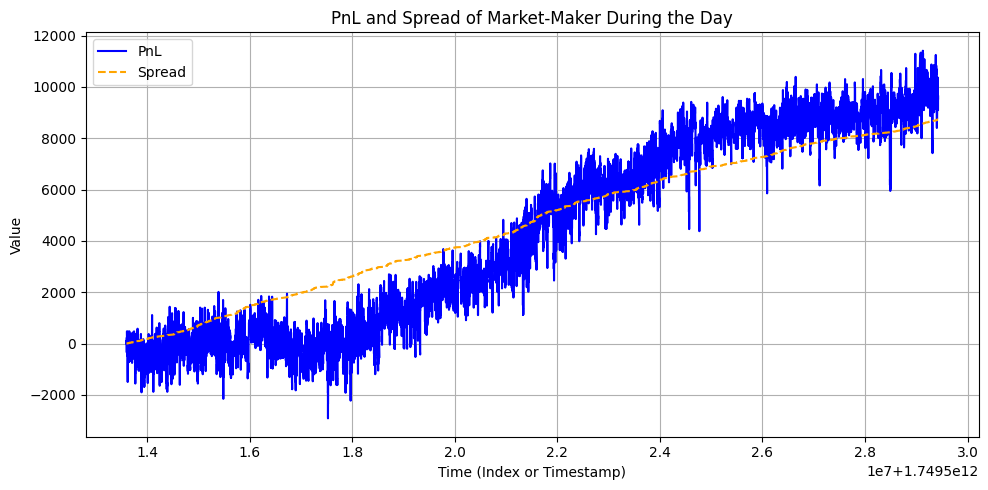

In [8]:
path = '/content/2025-06-10_BTCUSDT-26SEP25_ob500.txt'
loader = OrderBookLoader(path, rows_to_process = 100000)
loader.read_data()
realistic_hourly_pnl(loader, quote_interval=1, exit_interval=100, Price_factor=4.0, Vol_factor=0.5, Max_inventory=1.0, MARKET_NEUTRAL=True)

Final Inventory: 3.09 | Final PNL: 7093.83
PNL to Spread Ratio: 0.8126


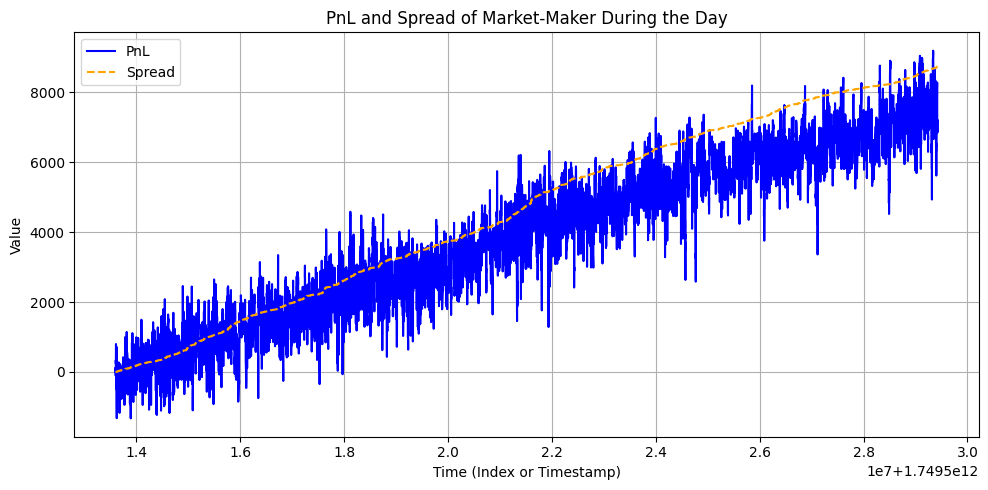

In [9]:
realistic_hourly_pnl(loader, exit_interval=200, Price_factor=1, Vol_factor=0.02, Max_inventory=0.5)